### Load data

In [8]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv("../complete-merged-df.csv", index_col=0, parse_dates=True)
df.head()

,close,open,high,low,estimated-transaction-volume-usd,n-transactions,hash-rate,difficulty,cost-per-transaction,Gold price,output-volume,trade-volume,USD-CNY Price,SVI,Wikiviews
2017-01-01,998.079443,966.567909,1005.074602,961.719392,1.667890e+08,180502.0,2.463611e+06,3.176884e+11,10.914479,1377.316553,1.084341e+06,3.989748e+06,6.72991,7.000000,3139
2017-01-02,1018.369458,998.079638,1033.051602,994.997792,2.799811e+08,290951.0,2.526780e+06,3.176884e+11,7.350606,1294.600000,1.573982e+06,6.822471e+06,6.94500,18.574713,9165
2017-01-03,1036.750461,1018.367417,1037.211425,1014.576142,3.417543e+08,301664.0,2.589950e+06,3.176884e+11,7.415466,1295.600000,1.950525e+06,8.324526e+06,6.96100,18.574713,12354
2017-01-04,1137.239897,1036.750186,1146.956329,1036.327096,4.336781e+08,328642.0,2.432026e+06,3.176884e+11,7.000531,1287.300000,2.482038e+06,9.340584e+06,6.93510,18.574713,10757
2017-01-05,1002.860000,1137.239606,1165.785631,883.480930,5.657800e+08,288501.0,2.210933e+06,3.176884e+11,6.913398,1287.400000,2.998215e+06,2.387011e+07,6.89000,18.574713,11938


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-01-01 to 2021-12-31
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   close                             1826 non-null   float64
 1   open                              1826 non-null   float64
 2   high                              1826 non-null   float64
 3   low                               1826 non-null   float64
 4   estimated-transaction-volume-usd  1826 non-null   float64
 5   n-transactions                    1826 non-null   float64
 6   hash-rate                         1826 non-null   float64
 7   difficulty                        1826 non-null   float64
 8   cost-per-transaction              1826 non-null   float64
 9   Gold price                        1826 non-null   float64
 10  output-volume                     1826 non-null   float64
 11  trade-volume                      1826 non-null   f

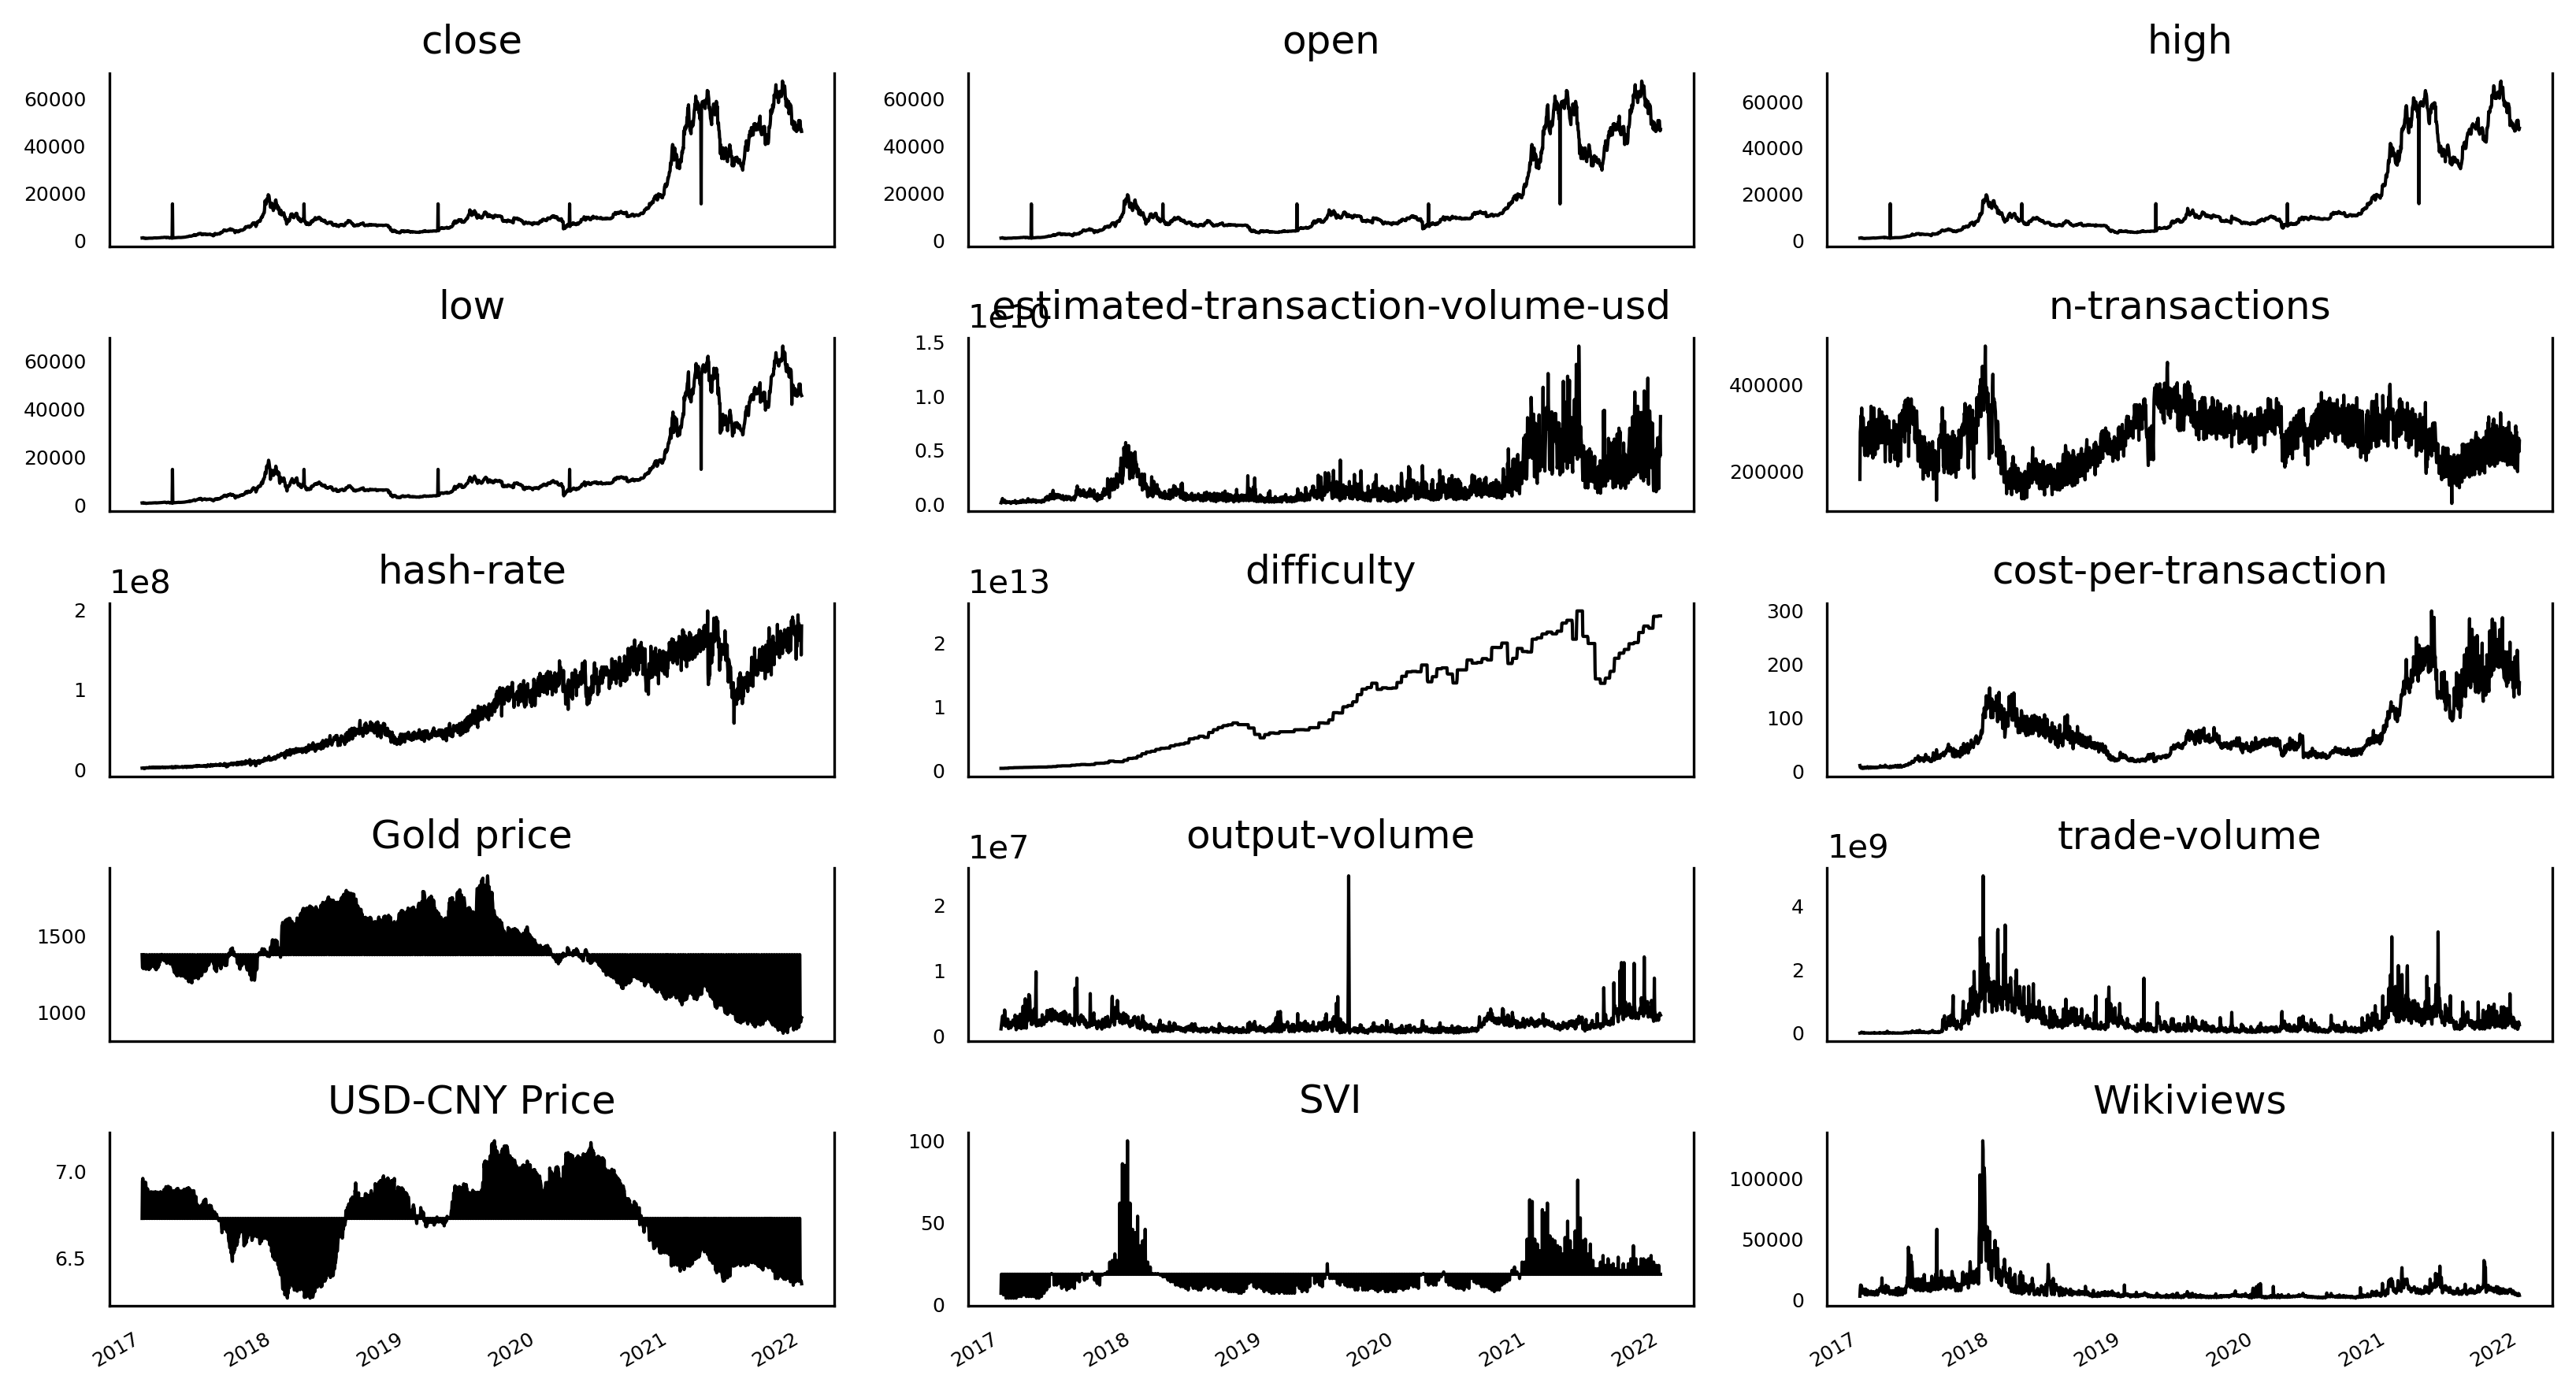

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=3, dpi=300, figsize=(11, 6))

for i, ax in enumerate(axes.flatten()[:15]):
    data = df[df.columns[i]]

    ax.plot(data, color='black', linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

fig.autofmt_xdate()
plt.tight_layout()


# Feature selection

In [9]:
from scipy.stats import linregress

def correlation_test(v1,v2, graph=False):
    coef = np.corrcoef(v1, v2)
    linreg = linregress(v1, v2)
    print("Coef : ", coef)
    print("Linear Regression results : ")
    print(f"\tp = {round(linreg.pvalue,5)}")
    print(f"\tslope = {round(linreg.slope,5)}")
    print(f"\tintercept = {round(linreg.intercept,5)}")
    print(f"\tstd. err = {round(linreg.stderr, 5)}")
    print("-----------------------------")
    if graph:
        plt.scatter(v1, v2)
        plt.show()

# correlation to btc closing price and miner revenue
def corr_plot(y_label, y_data, y2_label, y2_data, x):
    fig, ax1= plt.subplots()
    fig.set_figwidth(18)
    fig.set_figheight(10)

    ax1.set_xlabel('Date')
    ax1.tick_params(axis='x', bottom=False, labelbottom=False)

    ax1.set_ylabel(y_label, color='red', size='x-large')
    ax1.tick_params(axis='y', labelcolor='red', labelsize='large')
    ax1.plot(x, y_data, color='red')

    axprecip = ax1.twinx()
    axprecip.set_ylabel(y2_label, color='blue', size='x-large')
    axprecip.tick_params(axis='y', labelcolor='blue', labelsize='large')
    axprecip.plot(x, y2_data, color='blue')

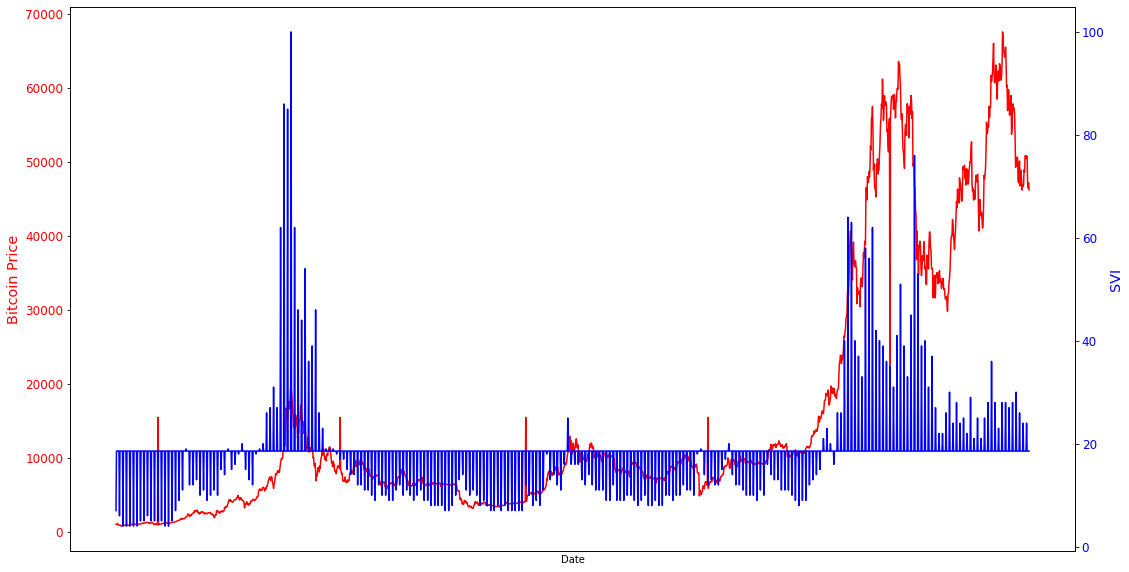

In [10]:
# plot correlation between btc closing price and Google Search hits
corr_plot("Bitcoin Price", df["close"], "SVI", df["SVI"], df.index)

In [11]:
# test correlation between features
correlation_test(df['n-transactions'],  df['SVI'])
correlation_test(df['close'],  df['cost-per-transaction'])
correlation_test(df['close'],  df['hash-rate'])
correlation_test(df['close'],  df['n-transactions'])
correlation_test(df['close'],  df['Gold price'])

Coef :  [[1.         0.04541802]
 [0.04541802 1.        ]]
Linear Regression results : 
	p = 0.05232
	slope = 0.0
	intercept = 17.2477
	std. err = 0.0
-----------------------------
Coef :  [[1.         0.92357215]
 [0.92357215 1.        ]]
Linear Regression results : 
	p = 0.0
	slope = 0.0032
	intercept = 22.48946
	std. err = 3e-05
-----------------------------
Coef :  [[1.         0.73883833]
 [0.73883833 1.        ]]
Linear Regression results : 
	p = 0.0
	slope = 2363.2308
	intercept = 38228360.55402
	std. err = 50.46946
-----------------------------
Coef :  [[ 1.        -0.0542155]
 [-0.0542155  1.       ]]
Linear Regression results : 
	p = 0.02051
	slope = -0.17781
	intercept = 285112.55332
	std. err = 0.07668
-----------------------------
Coef :  [[ 1.        -0.5926804]
 [-0.5926804  1.       ]]
Linear Regression results : 
	p = 0.0
	slope = -0.00762
	intercept = 1495.13593
	std. err = 0.00024
-----------------------------


In [15]:
# Close price correlation matrix
plt.figure(figsize=(10, 5))

k = len(df.columns)  # number of variables for heatmap
cols = df.corr().nlargest(k, 'close')['close'].index
cm = df[cols].corr()
cm.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\dell-2019\AppData\Local\Temp/ipykernel_8872/1106896653.py:7: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  cm.style.background_gradient(cmap='coolwarm').set_precision(2)


,close,high,low,open,cost-per-transaction,estimated-transaction-volume-usd,difficulty,hash-rate,output-volume,trade-volume,SVI,Wikiviews,n-transactions,USD-CNY Price,Gold price
close,1.00,1.00,1.00,1.00,0.92,0.83,0.74,0.74,0.32,0.26,0.22,0.05,-0.05,-0.46,-0.59
high,1.00,1.00,1.00,1.00,0.92,0.84,0.74,0.74,0.32,0.27,0.22,0.06,-0.05,-0.47,-0.59
low,1.00,1.00,1.00,1.00,0.92,0.82,0.74,0.74,0.32,0.25,0.21,0.05,-0.06,-0.46,-0.59
open,1.00,1.00,1.00,1.00,0.92,0.83,0.74,0.74,0.32,0.26,0.22,0.05,-0.06,-0.46,-0.59
cost-per-transaction,0.92,0.92,0.92,0.92,1.00,0.73,0.58,0.60,0.23,0.38,0.26,0.16,-0.23,-0.51,-0.43
estimated-transaction-volume-usd,0.83,0.84,0.82,0.83,0.73,1.00,0.62,0.62,0.33,0.42,0.20,0.23,0.15,-0.47,-0.58
difficulty,0.74,0.74,0.74,0.74,0.58,0.62,1.00,0.98,0.07,0.00,0.11,-0.28,0.13,-0.10,-0.49
hash-rate,0.74,0.74,0.74,0.74,0.60,0.62,0.98,1.00,0.08,-0.01,0.12,-0.28,0.18,-0.10,-0.48
output-volume,0.32,0.32,0.32,0.32,0.23,0.33,0.07,0.08,1.00,0.05,0.08,0.22,0.09,-0.22,-0.37
trade-volume,0.26,0.27,0.25,0.26,0.38,0.42,0.00,-0.01,0.05,1.00,0.19,0.57,-0.08,-0.45,-0.03


<Figure size 720x360 with 0 Axes>

In [17]:
array = df.values
X = array[:, 1:]
Y = array[:, 0].astype('int')

X.shape, Y.shape

((1826, 14), (1826,))

## Feature Selection
Hear we perform
<br>
    - Grid search with a regression model to find the optimal number of features<br>
    - Cross Validation with Kfolds
<br>
And with this information we perform a Chi-Squared test to score the features, and then run a Recursive Feature Elemination with the resuts we got from the grid search ad the cross validation to select the best ranking features.


In [30]:
# KFold Gridsearch for the best number of params for a Regression model
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# step-1: create a cross-validation scheme
folds = KFold(n_splits=10, shuffle=True, random_state=1)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(2, 15))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X, Y)
rfe = RFE(lm)

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator=rfe,
                        param_grid=hyper_params,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)
model_cv.fit(X, Y)

# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results[["param_n_features_to_select", "mean_test_score", "std_test_score",
            "mean_train_score", "std_train_score"]].sort_values(by=["mean_train_score", "param_n_features_to_select"], ascending=False)


Fitting 10 folds for each of 13 candidates, totalling 130 fits


,param_n_features_to_select,mean_test_score,std_test_score,mean_train_score,std_train_score
12,14,0.999430,0.000129,0.999464,0.000014
11,13,0.999432,0.000128,0.999464,0.000014
10,12,0.999430,0.000128,0.999463,0.000014
9,11,0.999434,0.000126,0.999462,0.000014
8,10,0.999434,0.000126,0.999462,0.000014
7,9,0.999435,0.000126,0.999462,0.000014
6,8,0.999434,0.000126,0.999461,0.000014
5,7,0.999434,0.000126,0.999460,0.000014
4,6,0.999434,0.000127,0.999460,0.000014
3,5,0.999189,0.000157,0.999208,0.000016


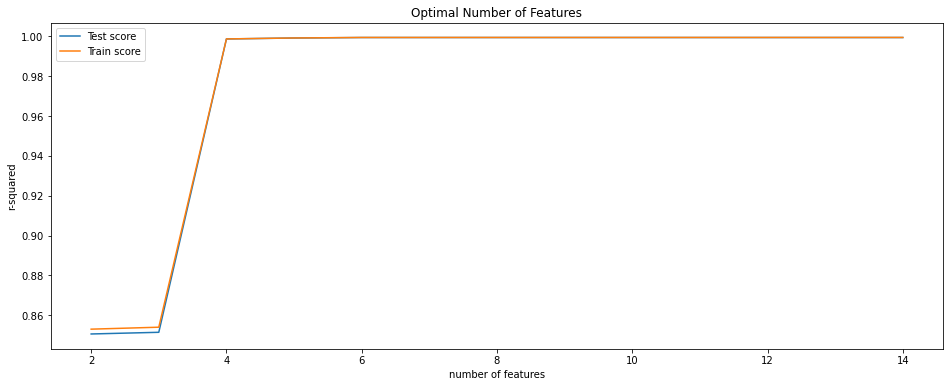

In [31]:
# plotting cv results
pyplot.figure(figsize=(16, 6))

pyplot.plot(cv_results["param_n_features_to_select"],
         cv_results["mean_test_score"])
pyplot.plot(cv_results["param_n_features_to_select"],
         cv_results["mean_train_score"])
pyplot.xlabel('number of features')
pyplot.ylabel('r-squared')
pyplot.title("Optimal Number of Features")
pyplot.legend(['Test score', 'Train score'], loc='upper left')


In [32]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# get a list of models to evaluate
def get_models():
	models = dict()

	for i in range(2, 15):
		model = LinearRegression()
		rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
# get the models to evaluate
models = get_models()

# evaluate the models and store results
folds = KFold(n_splits=10, shuffle=True, random_state=1)

results, names = list(), list()
for name, model in models.items():
	scores = cross_val_score(model, X, Y, scoring='r2', cv=folds)
	
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


>2 0.851 (0.019)
>3 0.851 (0.019)
>4 0.999 (0.000)
>5 0.999 (0.000)
>6 0.999 (0.000)
>7 0.999 (0.000)
>8 0.999 (0.000)
>9 0.999 (0.000)
>10 0.999 (0.000)
>11 0.999 (0.000)
>12 0.999 (0.000)
>13 0.999 (0.000)
>14 0.999 (0.000)


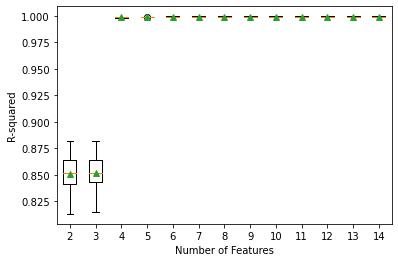

In [33]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xlabel('Number of Features')
pyplot.ylabel('R-squared')
pyplot.show()

In [34]:
results = [mean(x) for x in results] # calculate mean for each model score
scores = pd.DataFrame({"r2_score": results, "n_features": names}) # store results in dataframe
scores.sort_values(by="r2_score", ascending=False)[0:3] # top 3 scores 

,r2_score,n_features
7,0.999435,9
4,0.999434,6
5,0.999434,7


In [35]:
# CHI SQUARE TEST
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np

# Feature extraction
test = SelectKBest(score_func=chi2, k=9)
chifit = test.fit(X, Y)

# Summarize scores
np.set_printoptions(precision=3)
for score in list(zip(df.columns[1:], chifit.scores_)):
    print(score)

features = chifit.transform(X)

# Summarize selected features
# print(features)

('open', 33916452.45455666)
('high', 34854701.12206181)
('low', 32781929.246862635)
('estimated-transaction-volume-usd', 4043235767721.0327)
('n-transactions', 18811581.625176564)
('hash-rate', 70418673829.42184)
('difficulty', 9811861020852664.0)
('cost-per-transaction', 86731.38643786083)
('Gold price', 61294.52038742179)
('output-volume', 1558449011.6441996)
('trade-volume', 894684355465.4094)
('USD-CNY Price', 10.712471294511348)
('SVI', 3131.0185392246112)
('Wikiviews', 20788250.57341237)


In [36]:
# RFE - Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Feature extraction
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10, step=1)

fit = rfe.fit(X, Y)

print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

# create a dataframe with the selected features
features = pd.DataFrame(list(zip(df.columns[1:], fit.ranking_, fit.support_,  chifit.scores_.astype(int))),
                        columns=['Features', 'Ranking', 'RFE-Support', 'Chi-Support'])
features['RFE-Support'] = features['RFE-Support'].apply(lambda x: 'Selected' if x else 'Not Selected')
features.sort_values(by=['Ranking'], ascending=True)[:10]["Features"].to_list()


Num Features: 10
Selected Features: [ True  True  True False  True False False  True  True  True False  True
  True  True]
Feature Ranking: [1 1 1 4 1 2 5 1 1 1 3 1 1 1]


['open',
 'high',
 'low',
 'n-transactions',
 'cost-per-transaction',
 'Gold price',
 'output-volume',
 'USD-CNY Price',
 'SVI',
 'Wikiviews']

<AxesSubplot:xlabel='Ranking', ylabel='Features'>

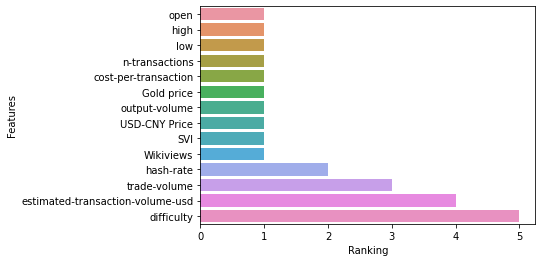

In [37]:
# plot features by rank
sns.barplot(x='Ranking', y='Features',
            data=features.sort_values(by=['Ranking']))


In [39]:
# AIC
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

y = df['close']  # define response variable

# 
predictors = df[features['Features'][:10].values]
X = sm.add_constant(predictors)  # add constant to predictor variables

#fit regression model
model = sm.OLS(y, X).fit()
model.summary()  # view AIC of model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.360e+05
Date:                Fri, 15 Apr 2022   Prob (F-statistic):               0.00
Time:                        22:45:38   Log-Likelihood:                -13503.
No. Observations:                1826   AIC:                         2.703e+04
Df Residuals:                    1815   BIC:                         2.709e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             -108.9460    102.038     -1.068      0.286    -309.069      91.177
open                                -0.4875      0.017    -28.944      0.000      -0.521      -0.454
high                                 0.9149      0.017     52.692      0.000       0.881       0.949
low                                  0.5633      0.013     43.530      0.000       0.538       0.589
estimated-transaction-volume-usd -2.152e-08   9.68e-09     -2.224      0.026   -4.05e-08   -2.54e-09
n-transactions                       0.0005      0.000      2.437      0.015       0.000       0.001
hash-rate                        -1.341e-08   9.77e-07     -0.014      0.989   -1.93e-06     1.9e-06
difficulty                        1.208e-12   7.14e-12      0.169      0.866   -1.28e-11    1.52e-11
cost-per-transaction                 1.3091      0.581      2.254      0.024       0.170       2.448
Gold price                          -0.0436      0.060     -0.724      0.469      -0.162       0.074
output-volume                    -3.344e-06   8.09e-06     -0.413      0.680   -1.92e-05    1.25e-05
==============================================================================
Omnibus:                      616.292   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16142.952
Skew:                          -0.997   Prob(JB):                         0.00
Kurtosis:                      17.429   Cond. No.                     1.41e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
print("AIC : ",model.aic)
print("R2 : ",model.rsquared)
print("Selected params : ",len(model.params.keys())-1)
aic_pvalues = pd.DataFrame(model.pvalues, columns=['p-values']).drop(['const'])
aic_pvalues['h0'] = aic_pvalues['p-values'].apply(lambda x: 'Rejected' if x < 0.05 else 'Not Rejected')
aic_pvalues["p-values"] = aic_pvalues["p-values"].apply(lambda x: '%.3f' % x)
aic_pvalues.sort_values(by='h0', ascending=False)

AIC :  27027.97821117696
R2 :  0.9994601400266162
Selected params :  10


,p-values,h0
open,0.000,Rejected
high,0.000,Rejected
low,0.000,Rejected
estimated-transaction-volume-usd,0.026,Rejected
n-transactions,0.015,Rejected
cost-per-transaction,0.024,Rejected
hash-rate,0.989,Not Rejected
difficulty,0.866,Not Rejected
Gold price,0.469,Not Rejected
output-volume,0.680,Not Rejected


# Unit Root Testing

In [41]:
from statsmodels.tsa.stattools import adfuller

def make_stationary(data: pd.Series, alpha: float = 0.05, max_diff_order: int = 10) -> dict:
    # Test to see if the time series is already stationary
    if adfuller(data)[1] < alpha:
        return {
            'differencing_order': 0,
            'time_series': np.array(data)
        }

    p_values = [] # A list to store P-Values
    # Test for differencing orders from 1 to max_diff_order (included)
    for i in range(1, max_diff_order + 1):
        result = adfuller(data.diff(i).fillna(data.mean())) # Perform ADF test
        p_values.append((i, result[1])) # Append P-value
        
    significant = [p for p in p_values if p[1] < alpha] # Keep only those where P-value is lower than significance level
    significant = sorted(significant, key=lambda x: x[0]) # Sort by the differencing order
    diff_order = significant[0][0] # Get the differencing order
    stationary_series = data.diff(diff_order).fillna(data.mean()) # Make the time series stationary
    
    return {
        'differencing_order': diff_order,
        'time_series': np.array(stationary_series)
    }

In [42]:
def test_stationarity(x, ax, name):
    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    ax.plot(x, color='blue',label='Original')
    ax.plot(rolmean, color='red', label='Rolling Mean')
    ax.plot(rolstd, color='black', label = 'Rolling Std')
    ax.set_title(name)

    #Perform Dickey Fuller test    
    result=adfuller(x)

    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])

    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;

   #  print('Critical values:')
   #  for key,value in result[4].items():
      #   print('\t%s: %.3f ' % (key, value))   

In [57]:
differenced_df = {}
for i in df.columns:
    ts = make_stationary(df[i])
    differenced_df[f'{i}_{ts["differencing_order"]}'] = ts["time_series"]
    print("Feature:",i, "\tp-value: ",adfuller(ts["time_series"])[1])

diff = pd.DataFrame(differenced_df).set_index(df.index)


Feature: close 	p-value:  0.0
Feature: open 	p-value:  0.0
Feature: high 	p-value:  0.0
Feature: low 	p-value:  0.0
Feature: estimated-transaction-volume-usd 	p-value:  3.769493174358308e-21
Feature: n-transactions 	p-value:  1.5353234813801808e-19
Feature: hash-rate 	p-value:  4.206086406638708e-26
Feature: difficulty 	p-value:  1.82727264718774e-21
Feature: cost-per-transaction 	p-value:  2.47661213954529e-14
Feature: Gold price 	p-value:  6.1865692944931675e-21
Feature: output-volume 	p-value:  0.023501458986675137
Feature: trade-volume 	p-value:  6.361865884193266e-22
Feature: USD-CNY Price 	p-value:  9.939303921043114e-21
Feature: SVI 	p-value:  0.006120240259034111
Feature: Wikiviews 	p-value:  0.016292859552655973


In [56]:
diff.head()

,close-1,open-1,high-1,low-1,estimated-transaction-volume-usd-1,n-transactions-1,hash-rate-1,difficulty-1,cost-per-transaction-1,Gold price-1,output-volume-0,trade-volume-1,USD-CNY Price-1,SVI-0,Wikiviews-0
2017-01-01,15470.656119,15446.307986,15900.046760,14932.582596,2.004009e+09,282361.699343,7.478909e+07,1.034516e+13,72.066568,1377.316553,1.084341e+06,3.828892e+08,6.72991,7.000000,3139
2017-01-02,20.290015,31.511729,27.977000,33.278400,1.131921e+08,110449.000000,6.316950e+04,0.000000e+00,-3.563874,-82.716553,1.573982e+06,2.832723e+06,0.21509,18.574713,9165
2017-01-03,18.381003,20.287779,4.159823,19.578350,6.177315e+07,10713.000000,6.316950e+04,0.000000e+00,0.064860,1.000000,1.950525e+06,1.502055e+06,0.01600,18.574713,12354
2017-01-04,100.489436,18.382769,109.744904,21.750954,9.192380e+07,26978.000000,-1.579238e+05,0.000000e+00,-0.414935,-8.300000,2.482038e+06,1.016058e+06,-0.02590,18.574713,10757
2017-01-05,-134.379897,100.489420,18.829302,-152.846166,1.321019e+08,-40141.000000,-2.210933e+05,0.000000e+00,-0.087133,0.100000,2.998215e+06,1.452953e+07,-0.04510,18.574713,11938


In [ ]:
# save differenced data
diff.to_csv('differenced_data.csv')

ADF Stastistic: -32.517135
p-value: 0.000000
The graph is stationery
ADF Stastistic: -30.989320
p-value: 0.000000
The graph is stationery
ADF Stastistic: -11.671803
p-value: 0.000000
The graph is stationery
ADF Stastistic: -3.581722
p-value: 0.006120
The graph is stationery


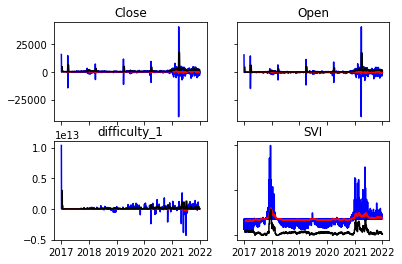

In [58]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
cols = diff.columns
test_stationarity(diff[cols[0]], ax=ax1, name="Close")
test_stationarity(diff[cols[1]], ax=ax2, name="Open")
test_stationarity(diff[cols[7]], ax=ax3, name=diff.columns[7])
test_stationarity(diff[cols[13]], ax=ax4, name="SVI")

for ax in fig.get_axes():
    ax.label_outer()
